In [84]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode
from tqdm import tqdm

from timeout import timeout

sys.path.append("../models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *

jax.config.update("jax_enable_x64", True)
%matplotlib inline

sys.path.insert(0, '../')
from utils import *

rng = np.random.default_rng(seed=1234)

# # On Martini set the visible GPU to the 2080Ti
# %env CUDA_VISIBLE_DEVICES=1

## Synthetic Data

In [10]:
# Kholodenko 2000
K_2000_idata, K_2000_ss, K_2000_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/kholodenko_2000/kholodenko_2000_smc_samples.json', sample_time=True)
K_2000_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/kholodenko_2000/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss, L_2000_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/levchenko_2000/levchenko_2000_smc_samples.json', sample_time=True)
L_2000_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/levchenko_2000/levchenko_2000_posterior_predictive_samples.npy')
# Hatakeyama 2003
HK_2003_idata, HK_2003_ss, HK_2003_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/hatakeyama_2003/hatakeyama_2003_smc_samples.json', sample_time=True)
HK_2003_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/hatakeyama_2003/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
H_2005_idata, H_2005_ss, H_2005_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/hornberg_2005/hornberg_2005_smc_samples.json', sample_time=True)
H_2005_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/hornberg_2005/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
B_2007_idata, B_2007_ss, B_2007_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/birtwistle_2007/birtwistle_2007_smc_samples.json', sample_time=True)
B_2007_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/birtwistle_2007/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss, O_2009_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/orton_2009/orton_2009_smc_samples.json', sample_time=True) 
O_2009_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/orton_2009/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
vK_2009_idata, VK_2009_ss, VK_2009_sampleTime = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_smc_samples.json', sample_time=True)
vK_2009_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss, S_2014_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/shin_2014/shin_2014_smc_samples.json', sample_time=True)
S_2014_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/shin_2014/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss, R_2015_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/ryu_2015/ryu_2015_smc_samples.json', sample_time=True)
R_2015_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/ryu_2015/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss, K_2017_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_traj_synthetic_data/kochanczyk_2017/kochanczyk_2017_smc_samples.json', sample_time=True) 
K_2017_post = np.load('../../../results/MAPK/param_est/HF96_traj_synthetic_data/kochanczyk_2017/kochanczyk_2017_posterior_predictive_samples.npy')

model_names = ['kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003','hornberg_2005', 'birtwistle_2007', 'orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names = ['Kholodenko 2000', 'Levchenko 2000', 'Katakeyama 2003','Hornberg 2005', 'Birtwistle 2007', 'Orton 2009', 'von Kriegsheim 2009', 'Shin 2014', 'Ryu 2015', 'Kochańczyk 2017']

# gather posterior samples
posterior_samples = [K_2000_post, L_2000_post, HK_2003_post, H_2005_post, B_2007_post, O_2009_post, vK_2009_post, S_2014_post, R_2015_post, K_2017_post]
idata = [K_2000_idata, L_2000_idata, HK_2003_idata, H_2005_idata, B_2007_idata, O_2009_idata, vK_2009_idata, S_2014_idata, R_2015_idata, K_2017_idata]

shin_id = 7
# shin has 4000 so downsample to 2000
idxs = rng.choice(np.arange(4000), size=2000, replace=False)
posterior_samples[shin_id] = S_2014_post[idxs,:,:]

inputs, data, data_std, times = load_data_json('../../../results/MAPK/HF_96_traj_data.json', data_std=True, time=True)
data_time_to_mins = 60


inputs_dose_response, data_dose_response = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest green
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
orange = '#de8f05'

Print sampling times for each model

In [11]:
print('kholodenko_2000:', K_2000_sample_time/3600, 'hr')
print('levchenko_2000:', L_2000_sample_time/3600, 'hr')
print('hatakeyama_2003:', HK_2003_sample_time/3600, 'hr')
print('hornberg_2005:', H_2005_sample_time/3600, 'hr')
print('birtwistle_2007:', B_2007_sample_time/3600, 'hr')
print('orton_2009:', O_2009_sample_time/3600, 'hr')
print('vonKriegsheim_2009', VK_2009_sampleTime/3600, 'hr')
print('shin_2014:', S_2014_sample_time/3600, 'hr')
print('ryu_2015:', R_2015_sample_time/3600, 'hr')
print('kochanczyk_2017:', K_2017_sample_time/3600, 'hr')


kholodenko_2000: 6.6200209453370835 hr
levchenko_2000: 0.4793780122200648 hr
hatakeyama_2003: 3.0087754978073966 hr
hornberg_2005: 12.131172452370325 hr
birtwistle_2007: 54.02403524299463 hr
orton_2009: 0.24648971736431122 hr
vonKriegsheim_2009 2.746477815045251 hr
shin_2014: 0.38646612101131017 hr
ryu_2015: 0.23467397226227654 hr
kochanczyk_2017: 1.919839056465361 hr


## Make pretty posterior predictive trajectories

plotting kholodenko_2000
plotting levchenko_2000


KeyboardInterrupt: 

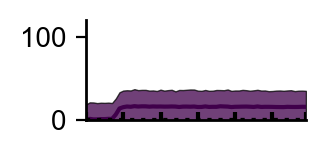

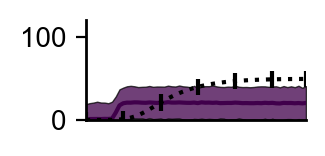

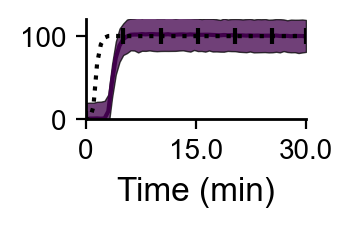

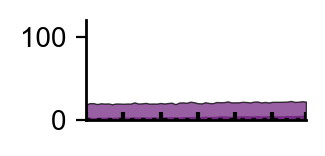

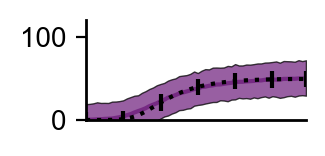

In [85]:
skip_idxs = []
for idx, model_name, post in zip(range(len(model_names)), model_names, posterior_samples):
    if idx in skip_idxs:
        print('skipping', model_name)
        continue
    else:
        print('plotting', model_name)
        plot_posterior_trajectories(post, data, data_std, times, colors[idx], 
                                        inputs, '../../../results/MAPK/param_est/HF96_traj_synthetic_data/'+model_name+'/', model_name, data_time_to_mins=60,
                                        width=1.1, height=0.5, data_downsample=10,
                                        ylim=[[0.0, 1.2], [0.0, 1.2], [0.0, 1.2]],
                                        y_ticks=[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])
plt.close('all')

## We also need to plot and analyze trajectories that are not posterior predictive, but simply use posterior samples to compute them

In [25]:
model_info = json.load(open('model_info.json', 'r'))

plotting_params = {
    'kholodenko_2000':[False,False,True,True],'levchenko_2000':[False,False,False,False],'hatakeyama_2003':[False,False,False,False],'hornberg_2005':[False,False,False,False],'birtwistle_2007':[False,False,False,False],'orton_2009':[True,True,True,True],'vonKriegsheim_2009':[True,True,False,False],'shin_2014':[True,True,False,False],'ryu_2015':[True,True,False,False],'kochanczyk_2017':[True,True,False,False]
}

n_traj = 400

skip_idxs = []
for idx,model in enumerate(model_info.keys()):
    if idx in skip_idxs:
        print('skipping', model)
        continue
    else:
        print('plotting', model)
        this_model_info = model_info[model]

        plot_p = plotting_params[model]

     
        # predict trajectories
        traj = predict_traj_response(model, idata[idx], inputs, times, 
                                              this_model_info['input_state'], this_model_info['ERK_states'],
                                              float(this_model_info['time_conversion']),
                                              EGF_conversion_factor=float(this_model_info['EGF_conversion_factor']),
                                              nsamples=400)
        # save
        np.save('../../../results/MAPK/param_est/HF96_traj_synthetic_data/'+model+'/traj_predict.npy', traj)

        # plot
        plot_posterior_trajectories(traj, data, data_std, times, colors[idx], 
                                        inputs, '../../../results/MAPK/param_est/HF96_traj_synthetic_data/'+model+'/',
                                        model, data_time_to_mins=60,
                                        width=1.1, height=0.5, 
                                        data_downsample=10,
                                        ylim=[[0.0, 1.2], [0.0, 1.2], [0.0, 1.2]],
                                        y_ticks=[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]],
                                        fname='_pred_traj_')
plt.close('all')

plotting kholodenko_2000


100%|██████████| 400/400 [00:03<00:00, 119.60it/s]


plotting levchenko_2000


100%|██████████| 400/400 [00:09<00:00, 43.95it/s] 


plotting hatakeyama_2003


100%|██████████| 400/400 [00:31<00:00, 12.57it/s]


plotting hornberg_2005


100%|██████████| 400/400 [12:43<00:00,  1.91s/it]


plotting birtwistle_2007


100%|██████████| 400/400 [07:01<00:00,  1.05s/it]


plotting orton_2009


100%|██████████| 400/400 [00:15<00:00, 26.31it/s]


plotting vonKriegsheim_2009


100%|██████████| 400/400 [00:17<00:00, 23.31it/s]
/Users/natetest/Library/CloudStorage/Dropbox/Mac (2)/Documents/phd/research/multimodel-inference/src/MAPK/param_est/../plotting_helper_funcs.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(fig_width, fig_height))


plotting shin_2014


100%|██████████| 400/400 [00:00<00:00, 1096.81it/s]


plotting ryu_2015


100%|██████████| 400/400 [00:06<00:00, 61.74it/s] 


plotting kochanczyk_2017


100%|██████████| 400/400 [00:10<00:00, 39.24it/s] 


## Now we want to use posterior draws to simulate dose-response curve predictions

skipping kholodenko_2000
skipping levchenko_2000
skipping hatakeyama_2003
skipping hornberg_2005
skipping birtwistle_2007
skipping orton_2009
plotting vonKriegsheim_2009


54it [00:27,  2.93s/it]

Function timed out. Skipping this sample. The params are [1.95000000e-04 6.85020315e-02 1.40000000e-03 1.16458092e-03
 9.10417443e-05 3.99300000e-01 4.66262558e-01 6.33203292e-01
 9.57499370e-02 1.40495479e+00 1.35661433e+00 9.63126650e-02
 1.22814202e-02 9.87950000e+00 1.75610000e+00 1.20000000e-03
 4.81180000e+00 5.03600000e-01 1.37360000e+00 8.44500000e-01
 3.48400000e-01 1.00000000e-01 0.00000000e+00 3.71000000e-02
 8.58125717e-02 1.00000000e+00 8.42200312e-02 8.89210124e-02
 2.45358409e-01 6.31404411e-04 1.49390000e+00 1.18019879e+00
 1.00000000e-01 5.98486023e-04 1.33010000e+00 5.13000000e-02
 4.22876999e-01 9.78100000e-01 1.00000000e-03 1.07977734e-01
 3.58677778e-03 6.44138174e-02 1.00000000e-01 5.00000000e+00
 1.00000000e+00 1.00000000e+00 7.90345221e-01 2.52620236e-01
 1.00000000e-03 3.66200000e-01 2.78000000e+00 1.30000000e-03
 9.97900000e-01 5.00000000e-03 8.80000000e-03 2.30000000e-03
 2.00000000e+00 9.98000000e-01 6.62100000e-01 1.82000000e-01
 9.78540000e+00 9.03400000e-

97it [00:54,  4.91s/it]

Function timed out. Skipping this sample. The params are [1.95000000e-04 3.20660327e-02 1.40000000e-03 3.58606953e-04
 1.95335369e-04 3.99300000e-01 2.85577317e-02 6.33203292e-01
 9.57499370e-02 1.92909159e-01 1.35661433e+00 9.63126650e-02
 5.45574839e-03 9.87950000e+00 1.75610000e+00 1.20000000e-03
 4.81180000e+00 5.03600000e-01 1.37360000e+00 8.44500000e-01
 3.48400000e-01 1.00000000e-01 0.00000000e+00 3.71000000e-02
 3.02253556e-02 1.00000000e+00 6.38082010e-02 6.01495994e-02
 1.78721253e-01 1.65633040e-03 1.49390000e+00 6.29305550e-01
 1.00000000e-01 6.12802383e-03 1.33010000e+00 5.13000000e-02
 1.09242863e+00 9.78100000e-01 1.00000000e-03 2.40127075e-01
 8.82842094e-02 6.05435536e-02 1.00000000e-01 5.00000000e+00
 1.00000000e+00 1.00000000e+00 7.90345221e-01 2.52620236e-01
 1.00000000e-03 3.66200000e-01 2.78000000e+00 1.30000000e-03
 9.97900000e-01 5.00000000e-03 8.80000000e-03 2.30000000e-03
 2.00000000e+00 9.98000000e-01 6.62100000e-01 1.82000000e-01
 9.78540000e+00 9.03400000e-

141it [01:20,  3.15s/it]

Function timed out. Skipping this sample. The params are [1.95000000e-04 4.52208853e-02 1.40000000e-03 1.41540714e-03
 1.64058453e-04 3.99300000e-01 1.92628323e-01 6.33203292e-01
 9.57499370e-02 1.99006212e-01 1.35661433e+00 9.63126650e-02
 1.25753557e-01 9.87950000e+00 1.75610000e+00 1.20000000e-03
 4.81180000e+00 5.03600000e-01 1.37360000e+00 8.44500000e-01
 3.48400000e-01 1.00000000e-01 0.00000000e+00 3.71000000e-02
 1.61231162e-02 1.00000000e+00 5.23735136e-01 3.95638181e-01
 2.11507659e-02 2.92178537e-04 1.49390000e+00 1.22884296e-02
 1.00000000e-01 8.29351920e-02 1.33010000e+00 5.13000000e-02
 4.89905341e+00 9.78100000e-01 1.00000000e-03 1.77564508e-01
 8.58346163e-05 8.10479955e-02 1.00000000e-01 5.00000000e+00
 1.00000000e+00 1.00000000e+00 7.90345221e-01 2.52620236e-01
 1.00000000e-03 3.66200000e-01 2.78000000e+00 1.30000000e-03
 9.97900000e-01 5.00000000e-03 8.80000000e-03 2.30000000e-03
 2.00000000e+00 9.98000000e-01 6.62100000e-01 1.82000000e-01
 9.78540000e+00 9.03400000e-

221it [01:53,  3.92s/it]

Function timed out. Skipping this sample. The params are [1.95000000e-04 2.75519911e-02 1.40000000e-03 8.48841295e-04
 1.96116050e-03 3.99300000e-01 1.76315732e-01 6.33203292e-01
 9.57499370e-02 1.62021459e+00 1.35661433e+00 9.63126650e-02
 4.07726872e-03 9.87950000e+00 1.75610000e+00 1.20000000e-03
 4.81180000e+00 5.03600000e-01 1.37360000e+00 8.44500000e-01
 3.48400000e-01 1.00000000e-01 0.00000000e+00 3.71000000e-02
 1.82234830e-02 1.00000000e+00 1.10375990e-01 1.08585313e-01
 1.01019773e-01 4.70334142e-04 1.49390000e+00 1.54946081e-01
 1.00000000e-01 7.42556315e-03 1.33010000e+00 5.13000000e-02
 2.05201969e+00 9.78100000e-01 1.00000000e-03 3.52898710e-02
 2.76142178e-02 2.11227229e-01 1.00000000e-01 5.00000000e+00
 1.00000000e+00 1.00000000e+00 7.90345221e-01 2.52620236e-01
 1.00000000e-03 3.66200000e-01 2.78000000e+00 1.30000000e-03
 9.97900000e-01 5.00000000e-03 8.80000000e-03 2.30000000e-03
 2.00000000e+00 9.98000000e-01 6.62100000e-01 1.82000000e-01
 9.78540000e+00 9.03400000e-

235it [02:16,  4.38s/it]

Function timed out. Skipping this sample. The params are [1.95000000e-04 1.05081703e-02 1.40000000e-03 3.74858306e-03
 1.88328295e-04 3.99300000e-01 9.90131957e-02 6.33203292e-01
 9.57499370e-02 4.10720583e-02 1.35661433e+00 9.63126650e-02
 7.76194500e-02 9.87950000e+00 1.75610000e+00 1.20000000e-03
 4.81180000e+00 5.03600000e-01 1.37360000e+00 8.44500000e-01
 3.48400000e-01 1.00000000e-01 0.00000000e+00 3.71000000e-02
 1.10358303e-03 1.00000000e+00 2.61021693e-01 3.15252572e-02
 8.59982983e-02 3.75469940e-04 1.49390000e+00 3.58145818e-01
 1.00000000e-01 1.14369587e-03 1.33010000e+00 5.13000000e-02
 7.26817306e-01 9.78100000e-01 1.00000000e-03 2.21383549e-01
 4.18999519e-04 3.94802130e-01 1.00000000e-01 5.00000000e+00
 1.00000000e+00 1.00000000e+00 7.90345221e-01 2.52620236e-01
 1.00000000e-03 3.66200000e-01 2.78000000e+00 1.30000000e-03
 9.97900000e-01 5.00000000e-03 8.80000000e-03 2.30000000e-03
 2.00000000e+00 9.98000000e-01 6.62100000e-01 1.82000000e-01
 9.78540000e+00 9.03400000e-

260it [02:40,  4.70s/it]

Function timed out. Skipping this sample. The params are [1.95000000e-04 1.05081703e-02 1.40000000e-03 3.74858306e-03
 1.88328295e-04 3.99300000e-01 9.90131957e-02 6.33203292e-01
 9.57499370e-02 4.10720583e-02 1.35661433e+00 9.63126650e-02
 7.76194500e-02 9.87950000e+00 1.75610000e+00 1.20000000e-03
 4.81180000e+00 5.03600000e-01 1.37360000e+00 8.44500000e-01
 3.48400000e-01 1.00000000e-01 0.00000000e+00 3.71000000e-02
 1.10358303e-03 1.00000000e+00 2.61021693e-01 3.15252572e-02
 8.59982983e-02 3.75469940e-04 1.49390000e+00 3.58145818e-01
 1.00000000e-01 1.14369587e-03 1.33010000e+00 5.13000000e-02
 7.26817306e-01 9.78100000e-01 1.00000000e-03 2.21383549e-01
 4.18999519e-04 3.94802130e-01 1.00000000e-01 5.00000000e+00
 1.00000000e+00 1.00000000e+00 7.90345221e-01 2.52620236e-01
 1.00000000e-03 3.66200000e-01 2.78000000e+00 1.30000000e-03
 9.97900000e-01 5.00000000e-03 8.80000000e-03 2.30000000e-03
 2.00000000e+00 9.98000000e-01 6.62100000e-01 1.82000000e-01
 9.78540000e+00 9.03400000e-

311it [03:12,  6.19s/it]

Function timed out. Skipping this sample. The params are [1.95000000e-04 8.91626506e-02 1.40000000e-03 5.55232799e-03
 1.25876584e-04 3.99300000e-01 1.73781225e-02 6.33203292e-01
 9.57499370e-02 1.02915962e-02 1.35661433e+00 9.63126650e-02
 2.76682536e-01 9.87950000e+00 1.75610000e+00 1.20000000e-03
 4.81180000e+00 5.03600000e-01 1.37360000e+00 8.44500000e-01
 3.48400000e-01 1.00000000e-01 0.00000000e+00 3.71000000e-02
 1.36307454e-02 1.00000000e+00 1.19211075e-01 1.13178695e-01
 1.73237909e-01 1.10539567e-04 1.49390000e+00 4.57830092e-01
 1.00000000e-01 3.58159099e-04 1.33010000e+00 5.13000000e-02
 1.45162958e+01 9.78100000e-01 1.00000000e-03 9.22106320e-02
 1.45246368e-03 8.79311797e-03 1.00000000e-01 5.00000000e+00
 1.00000000e+00 1.00000000e+00 7.90345221e-01 2.52620236e-01
 1.00000000e-03 3.66200000e-01 2.78000000e+00 1.30000000e-03
 9.97900000e-01 5.00000000e-03 8.80000000e-03 2.30000000e-03
 2.00000000e+00 9.98000000e-01 6.62100000e-01 1.82000000e-01
 9.78540000e+00 9.03400000e-

324it [03:35,  6.22s/it]

Function timed out. Skipping this sample. The params are [1.95000000e-04 1.05081703e-02 1.40000000e-03 3.74858306e-03
 1.88328295e-04 3.99300000e-01 9.90131957e-02 6.33203292e-01
 9.57499370e-02 4.10720583e-02 1.35661433e+00 9.63126650e-02
 7.76194500e-02 9.87950000e+00 1.75610000e+00 1.20000000e-03
 4.81180000e+00 5.03600000e-01 1.37360000e+00 8.44500000e-01
 3.48400000e-01 1.00000000e-01 0.00000000e+00 3.71000000e-02
 1.10358303e-03 1.00000000e+00 2.61021693e-01 3.15252572e-02
 8.59982983e-02 3.75469940e-04 1.49390000e+00 3.58145818e-01
 1.00000000e-01 1.14369587e-03 1.33010000e+00 5.13000000e-02
 7.26817306e-01 9.78100000e-01 1.00000000e-03 2.21383549e-01
 4.18999519e-04 3.94802130e-01 1.00000000e-01 5.00000000e+00
 1.00000000e+00 1.00000000e+00 7.90345221e-01 2.52620236e-01
 1.00000000e-03 3.66200000e-01 2.78000000e+00 1.30000000e-03
 9.97900000e-01 5.00000000e-03 8.80000000e-03 2.30000000e-03
 2.00000000e+00 9.98000000e-01 6.62100000e-01 1.82000000e-01
 9.78540000e+00 9.03400000e-

340it [03:58,  4.14s/it]

Function timed out. Skipping this sample. The params are [1.95000000e-04 1.05081703e-02 1.40000000e-03 3.74858306e-03
 1.88328295e-04 3.99300000e-01 9.90131957e-02 6.33203292e-01
 9.57499370e-02 4.10720583e-02 1.35661433e+00 9.63126650e-02
 7.76194500e-02 9.87950000e+00 1.75610000e+00 1.20000000e-03
 4.81180000e+00 5.03600000e-01 1.37360000e+00 8.44500000e-01
 3.48400000e-01 1.00000000e-01 0.00000000e+00 3.71000000e-02
 1.10358303e-03 1.00000000e+00 2.61021693e-01 3.15252572e-02
 8.59982983e-02 3.75469940e-04 1.49390000e+00 3.58145818e-01
 1.00000000e-01 1.14369587e-03 1.33010000e+00 5.13000000e-02
 7.26817306e-01 9.78100000e-01 1.00000000e-03 2.21383549e-01
 4.18999519e-04 3.94802130e-01 1.00000000e-01 5.00000000e+00
 1.00000000e+00 1.00000000e+00 7.90345221e-01 2.52620236e-01
 1.00000000e-03 3.66200000e-01 2.78000000e+00 1.30000000e-03
 9.97900000e-01 5.00000000e-03 8.80000000e-03 2.30000000e-03
 2.00000000e+00 9.98000000e-01 6.62100000e-01 1.82000000e-01
 9.78540000e+00 9.03400000e-

355it [04:21,  4.41s/it]

Function timed out. Skipping this sample. The params are [1.95000000e-04 8.70247895e-03 1.40000000e-03 1.47981100e-03
 1.05196126e-04 3.99300000e-01 1.33343552e-01 6.33203292e-01
 9.57499370e-02 3.38167453e-01 1.35661433e+00 9.63126650e-02
 3.02838058e-01 9.87950000e+00 1.75610000e+00 1.20000000e-03
 4.81180000e+00 5.03600000e-01 1.37360000e+00 8.44500000e-01
 3.48400000e-01 1.00000000e-01 0.00000000e+00 3.71000000e-02
 2.98865058e-01 1.00000000e+00 9.63135659e-03 2.18095959e-01
 1.03819029e-01 5.15465760e-04 1.49390000e+00 5.08269708e-01
 1.00000000e-01 2.67694916e-03 1.33010000e+00 5.13000000e-02
 2.68538885e+00 9.78100000e-01 1.00000000e-03 1.56733421e+00
 6.49387491e-04 2.04948870e-02 1.00000000e-01 5.00000000e+00
 1.00000000e+00 1.00000000e+00 7.90345221e-01 2.52620236e-01
 1.00000000e-03 3.66200000e-01 2.78000000e+00 1.30000000e-03
 9.97900000e-01 5.00000000e-03 8.80000000e-03 2.30000000e-03
 2.00000000e+00 9.98000000e-01 6.62100000e-01 1.82000000e-01
 9.78540000e+00 9.03400000e-

400it [04:28,  1.49it/s]


(400, 10)
skipping shin_2014
skipping ryu_2015
skipping kochanczyk_2017


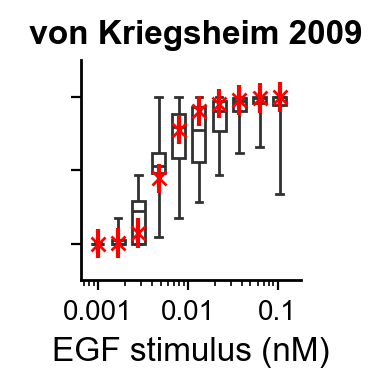

In [83]:
model_info = json.load(open('model_info.json', 'r'))

plotting_params = {
    'kholodenko_2000':[False,False,True,True],'levchenko_2000':[False,False,False,False],'hatakeyama_2003':[False,False,False,False],'hornberg_2005':[False,False,False,False],'birtwistle_2007':[False,False,False,False],'orton_2009':[True,True,True,True],'vonKriegsheim_2009':[True,True,False,False],'shin_2014':[True,True,False,False],'ryu_2015':[True,True,False,False],'kochanczyk_2017':[True,True,False,False]
}

skip_idxs = [0,1,2,3,4,5,7,8,9]
for idx,model in enumerate(model_info.keys()):
    if idx in skip_idxs:
        print('skipping', model)
        continue
    else:
        print('plotting', model)
        this_model_info = model_info[model]

        plot_p = plotting_params[model]

        # create dose-response curve prediction
        dose_response = predict_dose_response(model, idata[idx], inputs_dose_response,   
                                this_model_info['input_state'], this_model_info['ERK_states'], 
                                float(this_model_info['max_time']), EGF_conversion_factor=float(this_model_info['EGF_conversion_factor']), 
                                nsamples=400, timeout=20)
        print(dose_response.shape)
        # save
        np.save('../../../results/MAPK/param_est/HF96_traj_synthetic_data/'+model+'/dose_response_predict.npy', dose_response)

        fig, ax = plot_stimulus_response_curve(dose_response, data_dose_response, inputs_dose_response, input_name='EGF stimulus (nM)', output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                        data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0,
                                        title=this_model_info['display_name'], xlabel=plot_p[0],xticklabels=plot_p[1],ylabel=plot_p[2], yticklabels=plot_p[3])
        ax.set_title(ax.get_title(), fontsize=12.0)
        fig.savefig('../../../results/MAPK/param_est/HF96_traj_synthetic_data/'+model+'/dose_response_predict.pdf', transparent=True)


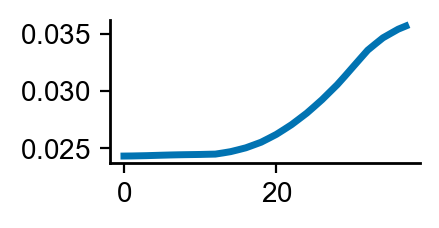

In [47]:
dat = np.array([0.02430687,0.02431452,0.02432863,0.02434297,0.02436283,0.02438208,0.02440009,0.02441545,0.02442762,0.02443718,0.02444718,0.02446368,0.024478,0.02458078,0.02469241,0.02485765,0.02502893,0.02527125,0.02551745,0.02585668,0.02620351,0.02662561,0.02705573,0.027559,0.02806609,0.02864914,0.02924129,0.02989964,0.03055656,0.03130131,0.03206414,0.03282364,0.03357919,0.03412593,0.03466094,0.03504022,0.03541715,0.03569278])

color='#0173b2'
fig, ax = get_sized_fig_ax(width=1.55, height=0.715)

ax.plot(np.arange(0,dat.shape[0],1), dat, color=color, linewidth=2.5, label='data')
fig.savefig('/Users/natetest/Downloads/tmp.pdf')